In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.optimizer import SPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage, ParamsStopping
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='reservations')
backend = provider.get_backend('ibmq_toronto')
backend

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='reservations')>

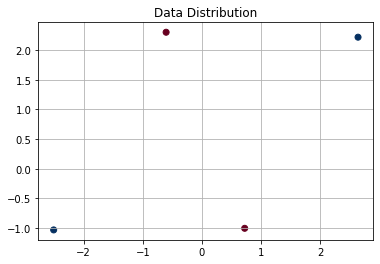

In [4]:
X, y = Example_4x2(True)()
Plot_Data(X, y).plot()

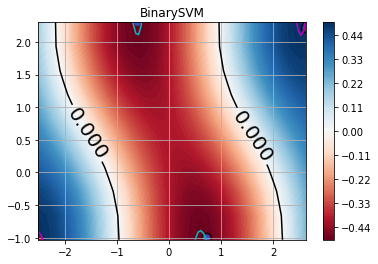

In [5]:
svm = BinarySVM(kernel=Kernel('SingleQubit'), C=None, k=10, mutation='REDUCED_QASVM')
svm.fit(X, y)
Plot_SVM(svm).plot_boundary()

In [6]:
var_form = RealAmplitudes(2, reps=1)
#quantum_instance = QuantumInstance(backend=QasmSimulator())
quantum_instance = QuantumInstance(backend=AerSimulator.from_backend(backend), shots=2**13, initial_layout=Qasvm_Mapping_4x2(backend), measurement_error_mitigation_cls=CompleteMeasFitter, optimization_level=3, seed_transpiler=0)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=100, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, idle_wires=False)

81


global phase: -π/2
              ┌────┐  ┌────────────────┐   ┌────┐  ┌────────┐     ┌───┐     ┌──────────┐┌────┐   ┌─────────┐                                                                                                                                                                                                                                                                                   ┌───┐      ┌────────────┐                                                                          ┌────┐                                ┌────┐                                                                               ┌────────────┐┌────┐┌────┐┌────────────┐                                                                                                                                                                                                                                                                     ░          
  i_0 -> 4 ───┤ √X ├──┤ RZ(θ_i[0] + π) ├───┤ √X ├──┤ RZ(3π) ├──■──┤ X ├──■──┤ RZ(3π/2) ├┤ √X ├───┤ RZ(π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ X ├───■──┤ RZ(7.8816) ├───────────────────────────────────────────────────────────────────────■──┤ √X ├────────────────────■───────────┤ √X ├────────────────────────────────────────────────────────────────────────────■──┤ RZ(2.5261) ├┤ √X ├┤ √X ├┤ RZ(4.0969) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
              ├────┤  ├────────────────┤   ├────┤  ├────────┤  │  └─┬─┘  │  └──┬───┬───┘├────┤┌──┴─────────┴───┐┌────┐┌────────┐               ┌───┐                                         ┌───┐                                                                                                                                                                                          │  └─┬─┘   │  └────────────┘               ┌───┐                                                   │  └────┘                    │           └────┘                                        ┌───┐                               │  └────────────┘└────┘└────┘└────────────┘                                                                                                                                                                                                                                                                     ░          
  i_1 -> 6 ───┤ √X ├──┤ RZ(θ_i[1] + π) ├───┤ √X ├──┤ RZ(3π) ├──┼────┼────┼─────┤ X ├────┤ √X ├┤ RZ(θ_i[3] + π) ├┤ √X ├┤ RZ(3π) ├─────────■─────┤ X ├───────■───────────────────────────■─────┤ X ├───────■───────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────────────■────────────────────────────────────┼────┼─────┼───────────────────────■───────┤ X ├──■────────────────────────────────────────────────┼────────────────────────────┼─────────────────────────────────────────────────────■───┤ X ├───────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
              ├────┤  └────────────────┘   └────┘  └────────┘┌─┴─┐  │  ┌─┴─┐   └─┬─┘    ├────┤├────────────────┤├────┤├────────┤       ┌─┴─┐   └─┬─┘     ┌─┴─┐                       ┌─┴─┐   └─┬─┘     ┌─┴─┐     ┌─────────┐   ┌────┐       ┌────┐                          ┌────────────┐┌────┐┌───────┐  ┌─┴─┐  ┌──

In [7]:
print(qasvm.first_order_circuit.depth())
qasvm.first_order_circuit.draw(fold=-1, idle_wires=False)

84


global phase: -π
              ┌────┐  ┌──────────────┐    ┌────┐        ┌────────┐                  ┌───┐     ┌──────────┐┌────┐  ┌─────────┐                                                                                                                                                                                                                                                                                                                      ┌───┐      ┌──────────┐                                                          ┌────┐                    ┌───────┐  ┌────┐                                                                                                                                                                                                                        ░       
  i_0 -> 4 ───┤ √X ├──┤ RZ(θ[0] + π) ├────┤ √X ├────────┤ RZ(3π) ├──────────■───────┤ X ├──■──┤ RZ(3π/2) ├┤ √X ├──┤ RZ(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├──────┤ RZ(5π/2) ├────────────────────────────────────────────────────■─────┤ √X ├───────────────■────┤ RZ(π) ├──┤ √X ├─────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────
              ├────┤  ├──────────────┤    ├────┤        ├────────┤          │       └─┬─┘  │  └──┬───┬───┘├────┤┌─┴─────────┴──┐┌────┐  ┌────────┐                                                                                                                                                                                                                                                                                                 └─┬─┘      └──────────┘┌───┐                                               │     └────┘               │    └───────┘  └────┘                             │                                                                                                                                                                                          ░       
  i_1 -> 6 ───┤ √X ├──┤ RZ(θ[1] + π) ├────┤ √X ├────────┤ RZ(3π) ├──────────┼─────────┼────┼─────┤ X ├────┤ √X ├┤ RZ(θ[3] + π) ├┤ √X ├──┤ RZ(3π) ├────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────■─────────────────────────────────────────────────────────────────────┼─────────────■──────┤ X ├──■────────────────────────────────────────────┼──────────────────────────┼──────────────────────────■───────────────────────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────
              ├────┤  └──────────────┘    └────┘        └────────┘        ┌─┴─┐       │  ┌─┴─┐   └─┬─┘    ├────┤├──────────────┤├────┤┌─┴────────┴─┐┌────┐     ┌────┐                 ┌────────────┐    ┌────┐    ┌────────────┐┌────┐┌────────────┐┌─┴─┐┌────┐┌────────────┐┌────┐┌───────┐┌───┐┌────────┐┌────┐┌────────────┐┌────┐┌─┴─┐┌─────────────┐┌───┐┌─────────────┐┌─┴─┐ ┌────────────┐     ┌────┐                  ┌───────┐ ┌────┐       │           ┌─┴─┐    └─┬─┘┌─┴─┐     ┌──────────┐┌────┐┌────┐┌─────────┐┌─┴─┐   ┌────┐ ┌──────────┐┌─┴─┐ ┌─────────┐ ┌────┐   ┌─┴─┐    ┌──────────┐   ┌─┴─┐    ┌─────────┐   ┌────┐  ┌──────────┐                                                                                                                                                  ░    ┌─┐
 yi_0 -> 7 ───┤ √X ├───────────────────────────────────────────

In [8]:
from tqdm.notebook import tqdm
import time

epochs = 2**6
last_avg = 2**3

start = time.time()

writer = SummaryWriter()
optimizer = SPSA(qasvm, blocking=True)

storage = CostParamStorage()

for epoch in tqdm(range(epochs)):
    optimizer.step(storage)
    if epoch==epochs/2:
        qasvm._quantum_instance = QuantumInstance(backend=backend, shots=2**13, initial_layout=Qasvm_Mapping_4x2(backend), measurement_error_mitigation_cls=CompleteMeasFitter, optimization_level=3, seed_transpiler=0)
qasvm.parameters = storage.data[storage.data.columns[1:5]].iloc[epochs-last_avg:].mean(axis=0).to_numpy()

  0%|          | 0/64 [00:00<?, ?it/s]

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

In [9]:
import seaborn as sns 
storage.data
import pandas as pd 

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

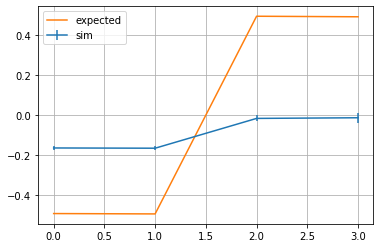

In [10]:
l = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(range(4), l.mean(axis=0), yerr=l.std(axis=0), label='sim')
plt.plot(svm.f(X), label='expected')
plt.legend()
plt.grid()

In [11]:
print('Used Time: {:} min'.format((time.time()-start)/60))

Used Time: 78.38398442665736 min


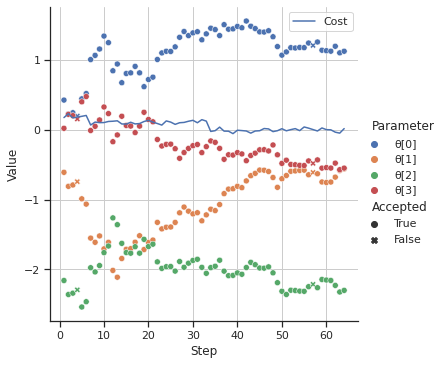

In [12]:
df = pd.melt(storage.data, id_vars=['Step', 'Accepted'], value_vars=storage.data.columns[1:5], var_name='Parameter', value_name='Value')
sns.set_theme(style="ticks")
palette = sns.color_palette("rocket_r")
g = sns.relplot(data=df, x='Step', y='Value', hue='Parameter', style="Accepted", style_order=[True, False])
storage.data[storage.data['Accepted']==True].plot(x='Step', y='Cost', ax=g.ax)
plt.grid()


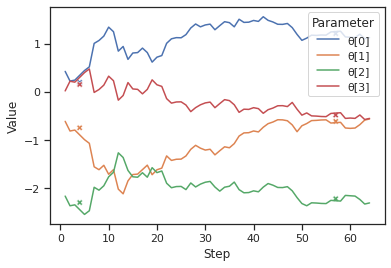

In [13]:
fig, ax = plt.subplots()
a=sns.lineplot(data=df[df['Accepted']==True], x='Step', y='Value', hue='Parameter', style_order=[True, False], ax=ax, legend=True)
b=sns.scatterplot(data=df[df['Accepted']==False], x='Step', y='Value', hue='Parameter', style="Accepted", style_order=[True, False], ax=ax, legend=False)

In [14]:
g.legend.properties()['bbox_to_anchor']

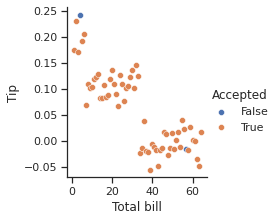

In [15]:
g = sns.FacetGrid(storage.data, hue='Accepted')
g.map_dataframe(sns.scatterplot, x='Step', y='Cost')
g.set_axis_labels("Total bill", "Tip")
g.add_legend()

In [16]:
df

,Step,Accepted,Parameter,Value
0,1,True,θ[0],0.425307
1,2,True,θ[0],0.224949
2,3,True,θ[0],0.244363
3,4,False,θ[0],0.196792
4,5,True,θ[0],0.442684
...,...,...,...,...
251,60,True,θ[3],-0.541220
252,61,True,θ[3],-0.547852
253,62,True,θ[3],-0.477364
254,63,True,θ[3],-0.571687


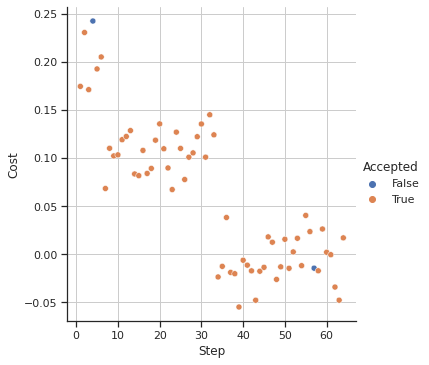

In [17]:
sns.relplot(data=storage.data, x='Step', y='Cost', hue='Accepted', style_order=[True, False])
plt.grid()

In [18]:
storage.data

,Step,θ[0],θ[1],θ[2],θ[3],Cost,Step Size,Accepted
1,1,0.425307,-0.609262,-2.157877,0.020979,0.174502,0.389541,True
2,2,0.224949,-0.809621,-2.358236,0.221338,0.230574,0.400717,True
3,3,0.244363,-0.790206,-2.338821,0.201923,0.171090,0.038830,True
4,4,0.196792,-0.742634,-2.291249,0.154351,0.242512,0.095143,False
5,5,0.442684,-0.988526,-2.537141,0.400243,0.192636,0.396641,True
...,...,...,...,...,...,...,...,...
60,60,1.131849,-0.754804,-2.150831,-0.541220,0.001908,0.014909,True
61,61,1.125218,-0.748173,-2.157462,-0.547852,-0.000648,0.013263,True
62,62,1.195706,-0.677685,-2.227950,-0.477364,-0.034320,0.140976,True
63,63,1.101382,-0.583361,-2.322273,-0.571687,-0.047972,0.188648,True


In [19]:
storage.data[storage.data.columns[1:5]].to_numpy()

array([[ 0.42530718, -0.60926212, -2.157877  ,  0.02097914],
       [ 0.22494855, -0.80962075, -2.35823563,  0.22133777],
       [ 0.24436342, -0.79020587, -2.33882076,  0.2019229 ],
       [ 0.19679189, -0.74263434, -2.29124922,  0.15435136],
       [ 0.44268386, -0.98852631, -2.5371412 ,  0.40024334],
       [ 0.51837975, -1.0642222 , -2.46144531,  0.47593922],
       [ 1.00491649, -1.55075894, -1.97490857, -0.01059752],
       [ 1.06510653, -1.61094898, -2.03509861,  0.04959253],
       [ 1.15623486, -1.51982065, -1.94397028,  0.14072086],
       [ 1.34168049, -1.70526627, -1.75852465,  0.32616649],
       [ 1.24721646, -1.61080225, -1.66406063,  0.23170246],
       [ 0.84453056, -2.01348815, -1.26137472, -0.17098345],
       [ 0.94155374, -2.11051134, -1.35839791, -0.07396026],
       [ 0.67393748, -1.84289508, -1.62601416,  0.193656  ],
       [ 0.80571582, -1.71111675, -1.7577925 ,  0.06187766],
       [ 0.81462352, -1.70220904, -1.7667002 ,  0.05296996],
       [ 0.9074405 , -1.

In [30]:
qasvm.save('./qasvm1.pkl')

In [21]:
storage.save('./storage1.pkl')

In [22]:
import dill
with open('_l.pkl', 'wb') as f:
    dill.dump(l, f)

In [25]:
optimizer._nfev

193

In [29]:
qasvm

Dual_QASVM (C=100, k=10)
Circuit Class: Bloch_sphere_QASVM_circuit
QuantumInstance: 
Qiskit Terra version: 0.17.1
Backend: 'ibmq_toronto (<AccountProvider for IBMQ(hub='ibm-q-kaist', group='internal', project='reservations')>)', with following setting:
{'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'], 'coupling_map': [[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [14, 16], [15, 12], [15, 18], [16, 14], [16, 19], [17, 18], [18, 15], [18, 17], [18, 21], [19, 16], [19, 20], [19, 22], [20, 19], [21, 18], [21, 23], [22, 19], [22, 25], [23, 21], [23, 24], [24, 23], [24, 25], [25, 22], [25, 24], [25, 26], [26, 25]]}
{'initial_layout': Layout({
12: Qubit(QuantumRegister(1, 'a'), 0),
4: Qubit(QuantumRegister(2, 'i'), 0),
6: Qubit(QuantumRegister(2, 'i'), 1),
10: Qubit(

In [28]:
storage.data[storage.data.columns[1:5]].iloc[epochs-last_avg:].mean(axis=0).to_numpy()

array([ 1.16035473, -0.66394444, -2.22175583, -0.5183056 ])